To do:
1. Keep norm_cat, embed pairs that have at least 2/3 of the norms in the norm_cat


In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import json
import pickle

## Loading results

In [2]:
norms = pd.read_csv('../../data/psychNorms/psychNorms.zip', index_col=0, low_memory=False)
rca_full = pd.read_csv('../../data/results/rca.csv')
meta = pd.read_csv('../../data/psychNorms/psychNorms_metadata.csv', index_col='norm')

print(f"# Norms: {len(meta.index.unique())}")
print(f"# Norm categories: {len(meta['category'].unique())}")
print(f"# Embeds: {len(rca_full['embed'].unique())}")

# Adding norm category
rca_full['norm_category'] = (
    rca_full['norm'].apply(lambda norm: meta.loc[norm]['category'])
    .replace({'_': ' '}, regex=True)
)
rca_full

# Norms: 292
# Norm categories: 27
# Embeds: 25


,embed,embed_type,norm,train_n,test_n,p,r2_mean,r2_sd,mse_mean,mse_sd,check,norm_category
0,CBOW_GoogleNews,text,Freq_HAL,28012,7003,300,0.522118,0.008398,2.715453,0.072527,pass,frequency
1,CBOW_GoogleNews,text,Freq_KF,19285,4822,300,0.500425,0.009710,0.156666,0.004775,pass,frequency
2,CBOW_GoogleNews,text,Freq_SUBTLEXUS,28636,7159,300,0.537265,0.009814,0.361345,0.007803,pass,frequency
3,CBOW_GoogleNews,text,Freq_SUBTLEXUK,29316,7330,300,0.545643,0.008416,0.446042,0.009075,pass,frequency
4,CBOW_GoogleNews,text,Freq_Blog,31876,7969,300,0.523700,0.008448,0.400166,0.009345,pass,frequency
...,...,...,...,...,...,...,...,...,...,...,...,...
7295,THINGS,behavior,familiarity_vanarsdall,376,95,49,0.091050,0.077868,3216.050320,580.598768,pass,familiarity
7296,THINGS,behavior,imageability_vanarsdall,376,95,49,0.074112,0.090266,1317.411401,292.505564,pass,imageability
7297,THINGS,behavior,familiarity_fear,173,44,49,0.151637,0.158767,0.782185,0.220500,pass,familiarity
7298,THINGS,behavior,aoa_fear,173,44,49,0.015012,0.129597,0.514519,0.043528,pass,age of acquisition


In [3]:
# Dropping compo attibs, nans, and cases where test_n > 20
rca = rca_full.query('embed != "compo_attribs" & test_n > 20').dropna()
rca

,embed,embed_type,norm,train_n,test_n,p,r2_mean,r2_sd,mse_mean,mse_sd,check,norm_category
0,CBOW_GoogleNews,text,Freq_HAL,28012,7003,300,0.522118,0.008398,2.715453,0.072527,pass,frequency
1,CBOW_GoogleNews,text,Freq_KF,19285,4822,300,0.500425,0.009710,0.156666,0.004775,pass,frequency
2,CBOW_GoogleNews,text,Freq_SUBTLEXUS,28636,7159,300,0.537265,0.009814,0.361345,0.007803,pass,frequency
3,CBOW_GoogleNews,text,Freq_SUBTLEXUK,29316,7330,300,0.545643,0.008416,0.446042,0.009075,pass,frequency
4,CBOW_GoogleNews,text,Freq_Blog,31876,7969,300,0.523700,0.008448,0.400166,0.009345,pass,frequency
...,...,...,...,...,...,...,...,...,...,...,...,...
7295,THINGS,behavior,familiarity_vanarsdall,376,95,49,0.091050,0.077868,3216.050320,580.598768,pass,familiarity
7296,THINGS,behavior,imageability_vanarsdall,376,95,49,0.074112,0.090266,1317.411401,292.505564,pass,imageability
7297,THINGS,behavior,familiarity_fear,173,44,49,0.151637,0.158767,0.782185,0.220500,pass,familiarity
7298,THINGS,behavior,aoa_fear,173,44,49,0.015012,0.129597,0.514519,0.043528,pass,age of acquisition


## Dropping norms with less than 2/3 of the norms in the norm category

In [4]:
def groupby_pivot(df):
    return(
        df.groupby(['embed', 'norm_category'], as_index=False).count()
        .pivot(index='embed', columns='norm_category', values='norm')
    )

rca_full_counts = groupby_pivot(rca_full[['embed', 'norm_category', 'norm']])
rca_counts =  groupby_pivot(rca[['embed', 'norm_category', 'norm']])

rca_full_counts, rca_counts = rca_full_counts.align(rca_counts, join='outer')
perc_retained = ((rca_counts / rca_full_counts) * 100)
perc_retained

norm_category,age of acquisition,animacy,arousal,associatability,autidtory lexical decision,concreteness,dominance,emotion,familiarity,frequency,...,recognition memory,semantic decision,semantic diversity,semantic neighborhood,sensory,social/moral,space/time/quantity,this/that,valence,visual lexical decision
embed,,,,,,,,,,,,,,,,,,,,,
CBOW_GoogleNews,100.00,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.0,...,100.0,100.0,100.000000,100.000000,100.000000,100.00,100.0,100.0,100.000000,100.0
EEG_speech,75.00,100.000000,77.777778,33.333333,100.0,100.000000,100.0,77.419355,31.818182,100.0,...,100.0,70.0,72.727273,100.000000,72.222222,62.50,96.0,100.0,66.666667,100.0
EEG_text,81.25,100.000000,88.888889,33.333333,100.0,100.000000,100.0,80.645161,59.090909,100.0,...,100.0,90.0,72.727273,100.000000,77.777778,87.50,100.0,100.0,77.777778,100.0
GloVe_CommonCrawl,100.00,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.0,...,100.0,100.0,100.000000,100.000000,100.000000,100.00,100.0,100.0,100.000000,100.0
GloVe_Twitter,100.00,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.0,...,100.0,100.0,100.000000,100.000000,100.000000,100.00,100.0,100.0,100.000000,100.0
GloVe_Wikipedia,100.00,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.0,...,100.0,100.0,100.000000,100.000000,100.000000,100.00,100.0,100.0,100.000000,100.0
LexVec_CommonCrawl,100.00,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.0,...,100.0,100.0,100.000000,100.000000,100.000000,100.00,100.0,100.0,100.000000,100.0
PPMI_SVD_EAT,93.75,100.000000,100.000000,66.666667,100.0,100.000000,100.0,100.000000,95.454545,100.0,...,100.0,90.0,100.000000,100.000000,94.444444,100.00,100.0,100.0,100.000000,100.0
PPMI_SVD_SWOW,100.00,100.000000,100.000000,66.666667,100.0,100.000000,100.0,100.000000,100.000000,100.0,...,100.0,90.0,100.000000,85.714286,100.000000,100.00,100.0,100.0,100.000000,100.0


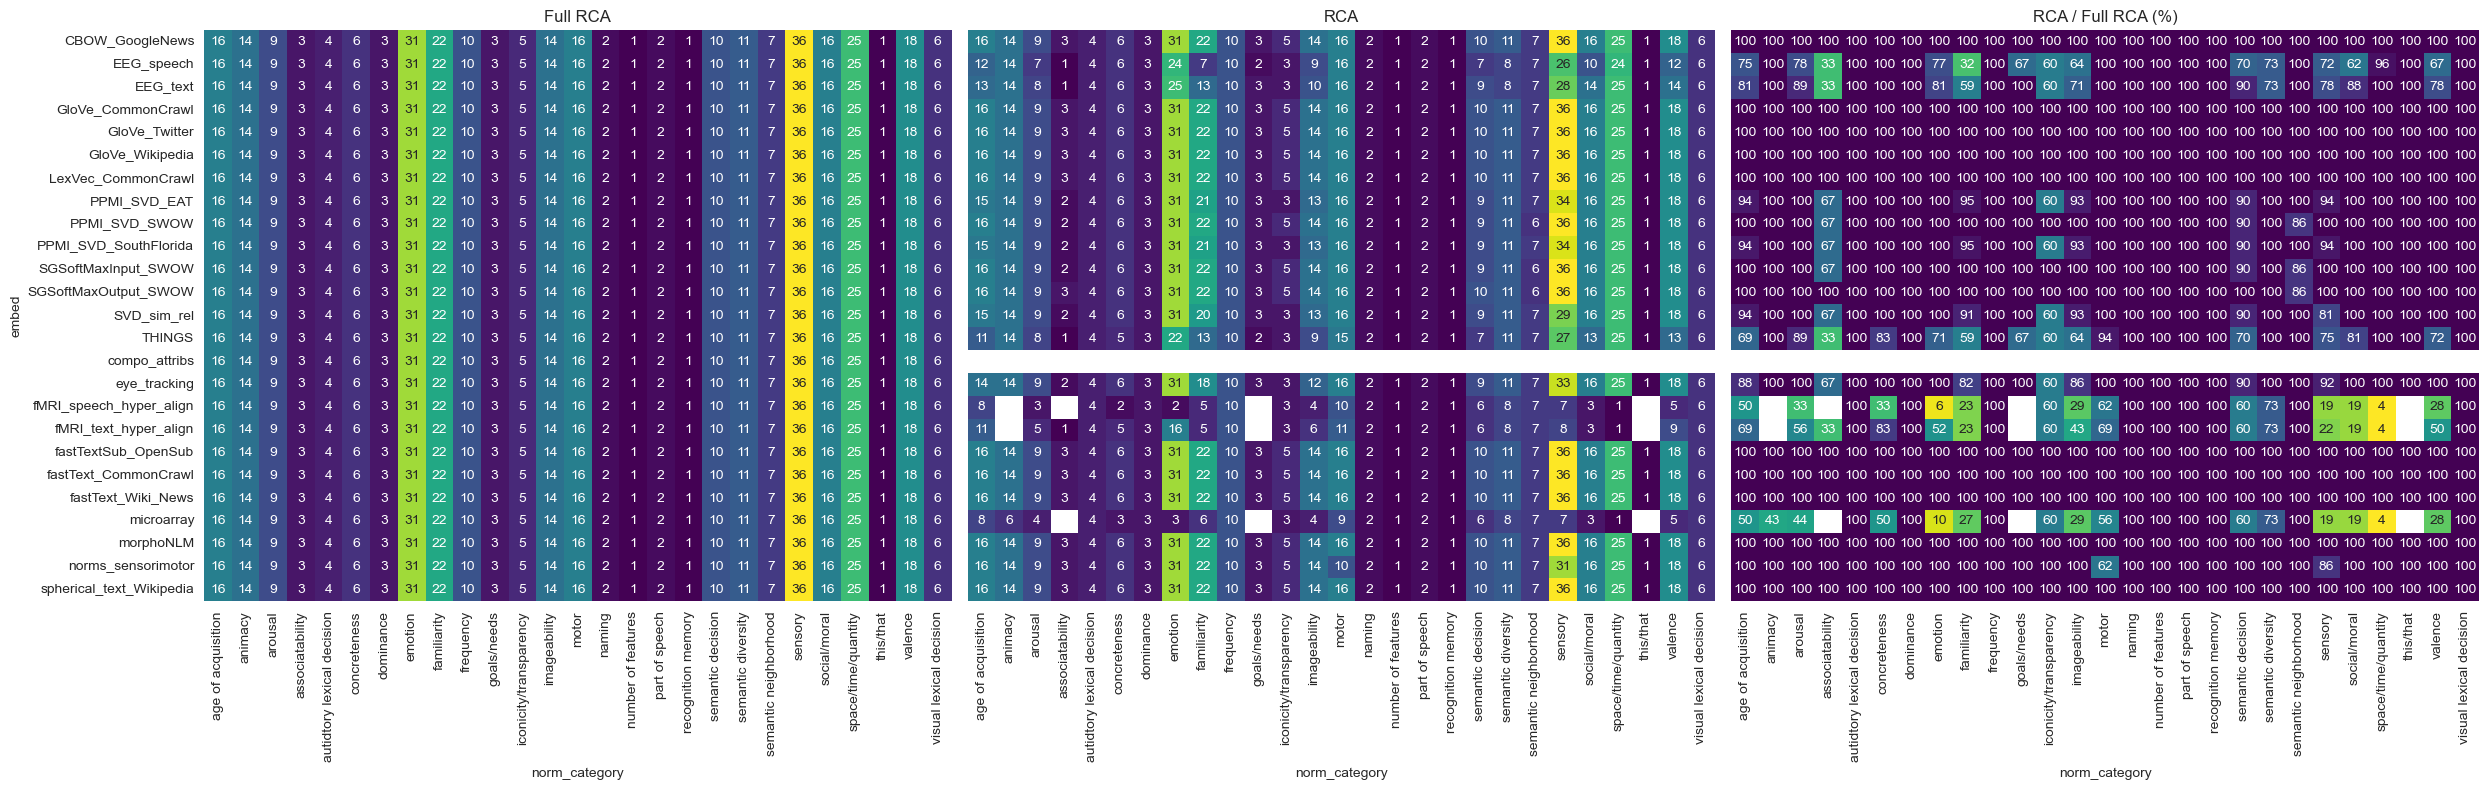

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(25, 8))

sns.heatmap(rca_full_counts, ax=axs[0], cmap='viridis', annot=True, fmt='g', cbar=False)

sns.heatmap(rca_counts, ax=axs[1], cmap='viridis', annot=True, fmt='g', cbar=False)

sns.heatmap(-perc_retained, ax=axs[2], cmap='viridis', annot=perc_retained.round(0), fmt='g', cbar=False)

axs[0].set_title('Full RCA')
axs[1].set_title('RCA')
axs[2].set_title('RCA / Full RCA (%)')

# remove y tick labels for all but the first plot
for ax in axs[1:]:
    ax.set(ylabel='')
    ax.set_yticklabels([])
    
fig.tight_layout()

In [6]:
# Stats reported in the paper
def avg_r2(embed, norm_category):
    avg_r2 = rca.query(f"embed == '{embed}' & norm_category == '{norm_category}'")['r2_mean'].median()
    print(f'{embed} {norm_category} avg r2: {round(avg_r2, 2)}')

# Mean r2s
avg_r2('CBOW_GoogleNews', 'part of speech')
avg_r2('CBOW_GoogleNews', 'animacy')
avg_r2('CBOW_GoogleNews', 'concreteness')

CBOW_GoogleNews part of speech avg r2: 0.66
CBOW_GoogleNews animacy avg r2: 0.71
CBOW_GoogleNews concreteness avg r2: 0.7


In [7]:
with open('../../data/embed_to_dtype.json', 'r') as f:
    embed_to_type = json.load(f)
    
rca['embed_type'] = rca['embed'].map(embed_to_type)
rca

,embed,embed_type,norm,train_n,test_n,p,r2_mean,r2_sd,mse_mean,mse_sd,check,norm_category
0,CBOW_GoogleNews,text,Freq_HAL,28012,7003,300,0.522118,0.008398,2.715453,0.072527,pass,frequency
1,CBOW_GoogleNews,text,Freq_KF,19285,4822,300,0.500425,0.009710,0.156666,0.004775,pass,frequency
2,CBOW_GoogleNews,text,Freq_SUBTLEXUS,28636,7159,300,0.537265,0.009814,0.361345,0.007803,pass,frequency
3,CBOW_GoogleNews,text,Freq_SUBTLEXUK,29316,7330,300,0.545643,0.008416,0.446042,0.009075,pass,frequency
4,CBOW_GoogleNews,text,Freq_Blog,31876,7969,300,0.523700,0.008448,0.400166,0.009345,pass,frequency
...,...,...,...,...,...,...,...,...,...,...,...,...
7295,THINGS,behavior,familiarity_vanarsdall,376,95,49,0.091050,0.077868,3216.050320,580.598768,pass,familiarity
7296,THINGS,behavior,imageability_vanarsdall,376,95,49,0.074112,0.090266,1317.411401,292.505564,pass,imageability
7297,THINGS,behavior,familiarity_fear,173,44,49,0.151637,0.158767,0.782185,0.220500,pass,familiarity
7298,THINGS,behavior,aoa_fear,173,44,49,0.015012,0.129597,0.514519,0.043528,pass,age of acquisition


In [8]:
# Taking the embedding with the highest avg r2 from each embed_type
top_embeds = (
    rca[['embed', 'embed_type', 'r2_mean']]
    .groupby(['embed', 'embed_type'], as_index=False)
    .median('r2_mean').set_index('embed')
    .groupby('embed_type').idxmax()['r2_mean']
)    

top_embeds

embed_type
behavior              PPMI_SVD_SWOW
brain       fMRI_speech_hyper_align
text                CBOW_GoogleNews
Name: r2_mean, dtype: object

In [9]:
# Ordering norms by top behavior model mean r2
top_behav= top_embeds['behavior']
norm_order = (
    rca[rca['embed'] == top_behav][['norm_category', 'r2_mean']]
    .groupby('norm_category').median().sort_values(by='r2_mean')
    .index
)
rca['norm_category'] = pd.Categorical(rca['norm_category'], norm_order)
rca = rca.sort_values(by='norm_category').reset_index(drop=True)
rca

,embed,embed_type,norm,train_n,test_n,p,r2_mean,r2_sd,mse_mean,mse_sd,check,norm_category
0,spherical_text_Wikipedia,text,LexicalD_ACC_A_MALD,16488,4122,300,-0.019660,0.081705,0.025834,0.013684,pass,autidtory lexical decision
1,PPMI_SVD_SWOW,behavior,LexicalD_ACC_A_AELP,5453,1364,300,0.125799,0.024195,0.007741,0.000494,pass,autidtory lexical decision
2,eye_tracking,brain,LexicalD_ACC_A_AELP,2460,616,6,-18.755978,37.482751,0.186946,0.361006,pass,autidtory lexical decision
3,eye_tracking,brain,LexicalD_ACC_A_MALD,4760,1190,6,-0.652116,1.306577,0.032055,0.036837,pass,autidtory lexical decision
4,EEG_text,brain,LexicalD_RT_A_AELP,1232,308,104,-0.002582,0.001345,0.008107,0.000391,pass,autidtory lexical decision
...,...,...,...,...,...,...,...,...,...,...,...,...
6242,SGSoftMaxOutput_SWOW,behavior,valence_garrido,244,62,300,0.481656,0.142563,1.083809,0.217826,pass,valence
6243,SGSoftMaxOutput_SWOW,behavior,valence_hollis,820,205,300,0.491126,0.114253,0.011394,0.002292,pass,valence
6244,LexVec_CommonCrawl,text,valence_citron,237,60,300,0.636496,0.149143,0.562195,0.122259,pass,valence
6245,PPMI_SVD_SWOW,behavior,Unpleasant_Binder,380,96,300,0.604057,0.069537,0.882121,0.069393,pass,valence


In [10]:
# rca average
rca_avg = (
    rca[['norm_category', 'embed', 'r2_mean']]
    .groupby(['norm_category', 'embed'], as_index=False).median()
)

rca_avg = rca_avg.pivot(index='embed', columns='norm_category', values='r2_mean')
rca_avg

norm_category,autidtory lexical decision,semantic decision,naming,familiarity,number of features,visual lexical decision,semantic neighborhood,associatability,age of acquisition,iconicity/transparency,...,this/that,sensory,emotion,goals/needs,animacy,arousal,concreteness,dominance,social/moral,valence
embed,,,,,,,,,,,,,,,,,,,,,
CBOW_GoogleNews,0.160777,0.124299,0.265076,0.316924,0.156893,0.365517,0.182791,0.250237,0.528642,0.318060,...,0.559614,0.590522,0.521944,0.512865,0.708571,0.540332,0.704512,0.498838,0.639605,0.643696
EEG_speech,-0.011122,-0.150650,-0.041741,-0.009213,-0.007355,-0.025405,-0.055312,-0.021250,-0.144143,-0.086432,...,-0.089141,-0.061014,-0.102030,-0.071493,-0.062606,-0.049592,-0.076180,-0.009880,-0.081447,-0.031951
EEG_text,-0.003230,-0.028552,-0.005751,-0.039066,-0.008482,-0.012066,-0.015566,-0.038361,-0.023821,-0.093978,...,-0.142636,-0.083851,-0.019014,-0.104324,-0.186480,-0.038429,-0.078904,-0.006034,-0.049937,-0.020548
GloVe_CommonCrawl,0.048212,-0.012816,0.026743,-0.049689,0.117200,0.081308,0.027508,-0.082646,0.402780,0.237838,...,0.433699,0.552368,0.482844,0.521409,0.676408,0.501339,0.683420,0.499238,0.661483,0.639887
GloVe_Twitter,-0.005276,-0.006467,-0.060822,0.064170,0.120785,0.129708,0.047796,-0.044025,0.255263,0.207831,...,0.422850,0.422093,0.358111,0.458540,0.586769,0.428176,0.567716,0.364736,0.537661,0.548663
GloVe_Wikipedia,0.000060,-0.003365,0.021734,0.065488,0.100848,0.089133,0.005656,0.117255,0.375740,0.173221,...,0.422045,0.422325,0.409698,0.459795,0.604395,0.361869,0.574582,0.385444,0.526845,0.514625
LexVec_CommonCrawl,0.052320,-0.017134,0.036564,-0.020474,0.125967,0.040040,-0.218411,-0.070276,0.170679,0.244497,...,0.464478,0.552567,0.519173,0.508659,0.696819,0.500268,0.678555,0.443872,0.626962,0.606405
PPMI_SVD_EAT,0.017864,0.045969,0.104489,0.082504,0.101340,0.186248,0.164263,0.109449,0.141246,0.207173,...,0.323163,0.474391,0.368988,0.402847,0.483129,0.370192,0.540804,0.442227,0.435829,0.457198
PPMI_SVD_SWOW,0.018782,0.082524,0.095261,0.120317,0.132298,0.146643,0.202379,0.207612,0.216044,0.282770,...,0.526228,0.558726,0.577780,0.602287,0.606707,0.618196,0.641820,0.644813,0.677847,0.719039


## Heatmap

In [11]:
winner_mask = rca_avg.apply(lambda col: col == col.max(), axis=0)
winner_mask

norm_category,autidtory lexical decision,semantic decision,naming,familiarity,number of features,visual lexical decision,semantic neighborhood,associatability,age of acquisition,iconicity/transparency,...,this/that,sensory,emotion,goals/needs,animacy,arousal,concreteness,dominance,social/moral,valence
embed,,,,,,,,,,,,,,,,,,,,,
CBOW_GoogleNews,True,True,True,True,True,True,False,False,True,True,...,True,True,False,False,True,False,False,False,False,False
EEG_speech,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
EEG_text,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
GloVe_CommonCrawl,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
GloVe_Twitter,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
GloVe_Wikipedia,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
LexVec_CommonCrawl,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PPMI_SVD_EAT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PPMI_SVD_SWOW,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,False,True,False,True,True,True


In [12]:
heat_dfs = {}
embed_types = ['text', 'brain', 'behavior']
for embed_type in embed_types:
    heat_df = rca_avg[[embed_to_type[embed] == embed_type for embed in rca_avg.index]]
    
    # Sorts index and columns
    embed_order = heat_df.mean(axis=1).sort_values(ascending=False).index
    heat_dfs[embed_type] = heat_df[norm_order].loc[embed_order]


In [13]:
def lighten_cmap(cmap, factor=0.3):
    cmap = plt.cm.get_cmap(cmap, 256)  # Get the original colormap
    colors = cmap(np.linspace(0, 1, 256))

    # Blend each color with white by adjusting RGB values
    white = np.array([1, 1, 1, 1])  # RGBA for white
    new_colors = (1 - factor) * colors + factor * white

    return LinearSegmentedColormap.from_list('lighter_' + cmap.name, new_colors)


def plot_colormap(cmap):
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))

    fig, ax = plt.subplots(figsize=(6, 2))
    ax.imshow(gradient, aspect='auto', cmap=cmap)
    ax.set_axis_off()
    plt.show()


# Custom colormap: viridis with white added
viridis = plt.cm.get_cmap('viridis', 256)
new_colors = viridis(np.linspace(0, 1, 256))

# Modify the first 30% of the colormap to blend with white
new_colors[:50, :] = [1, 1, 1, 1]  # Setting white for the first 50 values
custom_cmap = LinearSegmentedColormap.from_list('viridis_white', new_colors)

# Generate a lighter version of viridis
lighter_viridis = lighten_cmap('viridis', factor=0.6)  # factor closer to 1 means lighter

# Visualize the lighter viridis colormap
plot_colormap(lighter_viridis)

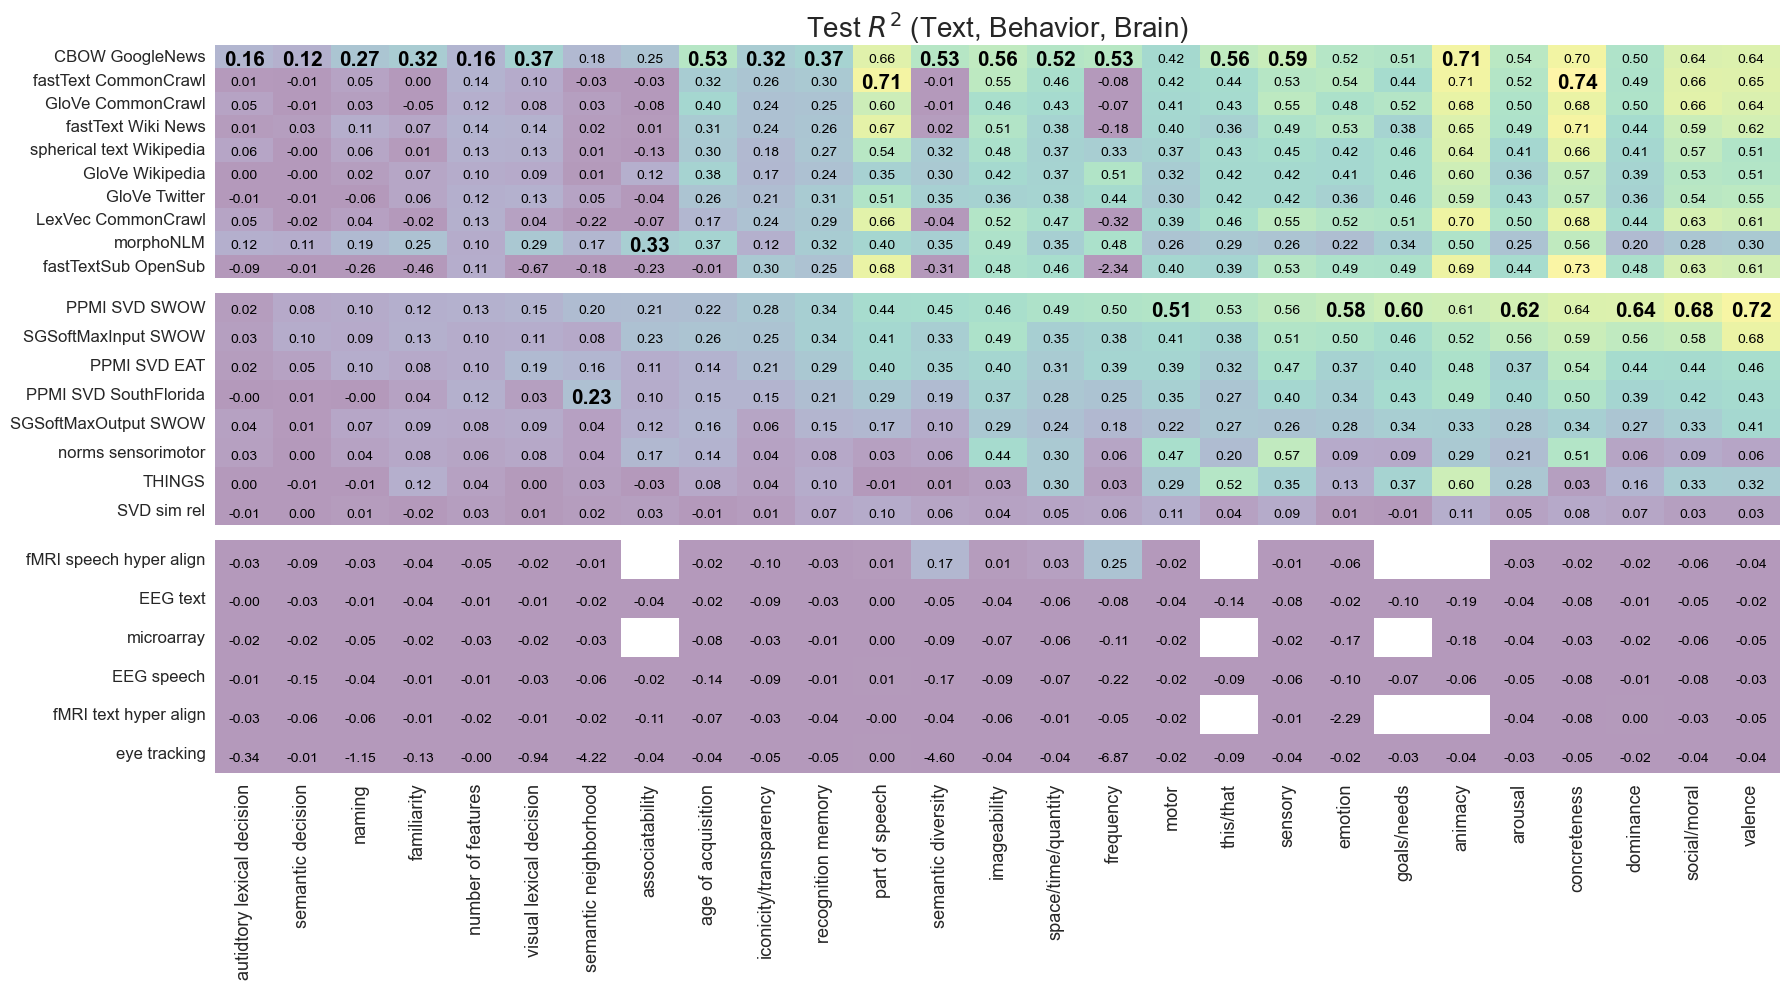

In [15]:
def annotate(heat_df, ax):
    for x, norm_cat in enumerate(heat_df.columns):
        for y, embed in enumerate(heat_df.index):
            annot = heat_df.loc[embed, norm_cat]
            
            # Scientific notation
            if abs(annot) > 1e3:
                annot = f'{annot:.1e}'
            elif np.isnan(annot):
                annot = ''
            else:
                annot = f'{annot:.2f}'
            
            # Fontsize and fontweight
            if winner_mask.loc[embed, norm_cat]:
                fontsize, fontweight = 15, 'bold'
            else:
                fontsize, fontweight = 10, 'normal'
            
            
            ax.text(
                x + .5, y + .6, annot, fontsize=fontsize, fontweight=fontweight,
                ha='center', va='center', color='black'
            )


fig, axs = plt.subplots(3, 1, figsize=(18, 10))

vmax = rca_avg.max().max()
for i, embed_type in enumerate(['text', 'behavior', 'brain']):
    heat_df = heat_dfs[embed_type]
    
    sns.heatmap(
        heat_df, ax=axs[i], vmin=0, cmap=lighter_viridis, 
        vmax=vmax, annot=False, fmt='', cbar=False,
        
    )
    axs[i].set(xlabel='', ylabel='', xticklabels=[])
    
    # Annotates cells
    annotate(heat_df, axs[i])
    
    
    # Ensure y-axis labels match the number of ticks
    axs[i].set_yticks(pd.Series(range(len(heat_df.index))) + .5)
    y_ticklabels = heat_df.index.str.replace('_', ' ', regex=True)
    axs[i].set_yticklabels(y_ticklabels, fontsize=12)
    
# Adding xticklabels to last plot
axs[-1].set_xticklabels(norm_order, rotation=90, fontsize=13)

# Sets figure title
axs[0].set_title('Test $R^2$ (Text, Behavior, Brain)', fontsize=20)
    
fig.tight_layout()
plt.savefig('../../figures/rca.png', dpi=300, bbox_inches='tight')

## Negative outlier checks

In [16]:
norms = pd.read_csv('../../data/psychNorms/psychNorms.zip', index_col=0, low_memory=False)

# Applying same transformations as in rca.ipynb
with open('../../data/norms_to_log.pkl', 'rb') as f:
    norms_to_log = pickle.load(f)
    norms[norms_to_log] = norms[norms_to_log].apply(np.log1p)

rca.sort_values(by='r2_mean', ascending=True)

,embed,embed_type,norm,train_n,test_n,p,r2_mean,r2_sd,mse_mean,mse_sd,check,norm_category
1073,GloVe_Wikipedia,text,Sem_N,26030,6508,300,-1129.665894,2238.304834,4.131099,2.596383,pass,semantic neighborhood
485,fastText_CommonCrawl,text,perc_known_britz,384,96,300,-90.666424,130.430043,78.229152,111.540150,pass,familiarity
1043,LexVec_CommonCrawl,text,Sem_N,26593,6649,300,-68.164842,128.865305,7.920860,6.084154,pass,semantic neighborhood
423,fastText_Wiki_News,text,perc_known_britz,384,96,300,-51.588416,91.639777,75.545371,98.628853,pass,familiarity
688,GloVe_CommonCrawl,text,perc_known_britz,384,96,300,-50.105035,68.526862,77.246114,112.198322,pass,familiarity
...,...,...,...,...,...,...,...,...,...,...,...,...
5862,PPMI_SVD_SWOW,behavior,likableness_chandler,408,103,300,0.854160,0.032139,0.334885,0.078969,pass,social/moral
3795,norms_sensorimotor,behavior,Smell_Binder,404,101,11,0.854866,0.024746,0.265353,0.027956,pass,sensory
4840,fastText_CommonCrawl,text,thought_vanarsdall,960,240,300,0.863282,0.025518,5614.468385,979.246925,pass,animacy
5016,THINGS,behavior,Biomotion_Binder,128,32,49,0.872332,0.042505,0.629167,0.237935,pass,animacy


In [17]:
# Problematic r2s
problematic = rca.query('r2_mean < -1 & embed_type.isin(["text", "behavior"]) & train_n > p')
problematic

,embed,embed_type,norm,train_n,test_n,p,r2_mean,r2_sd,mse_mean,mse_sd,check,norm_category
221,GloVe_Twitter,text,accuracy_chen,277,70,200,-2.829025,3.436655,0.036791,0.033222,pass,semantic decision
397,GloVe_Wikipedia,text,familiarity_lyn,320,80,300,-3.019070,3.579965,0.015811,0.016818,pass,familiarity
423,fastText_Wiki_News,text,perc_known_britz,384,96,300,-51.588416,91.639777,75.545371,98.628853,pass,familiarity
425,GloVe_Wikipedia,text,perc_known_britz,382,96,300,-6.175426,10.765756,61.809019,84.841947,pass,familiarity
435,fastText_Wiki_News,text,familiarity_lyn,320,80,300,-17.345480,21.721363,0.017813,0.015978,pass,familiarity
...,...,...,...,...,...,...,...,...,...,...,...,...
2970,fastTextSub_OpenSub,text,Freq_CobS,25999,6500,300,-2.926072,4.445264,0.239661,0.261344,pass,frequency
2972,fastTextSub_OpenSub,text,Freq_SUBTLEXUS,28666,7167,300,-4.365746,3.378428,0.797568,0.648582,pass,frequency
2976,fastText_Wiki_News,text,Freq_CobS,26636,6660,300,-5.321866,8.617481,0.211482,0.248905,pass,frequency
2986,fastText_Wiki_News,text,Freq_CobW,26636,6660,300,-3.245645,5.689130,0.183237,0.189531,pass,frequency


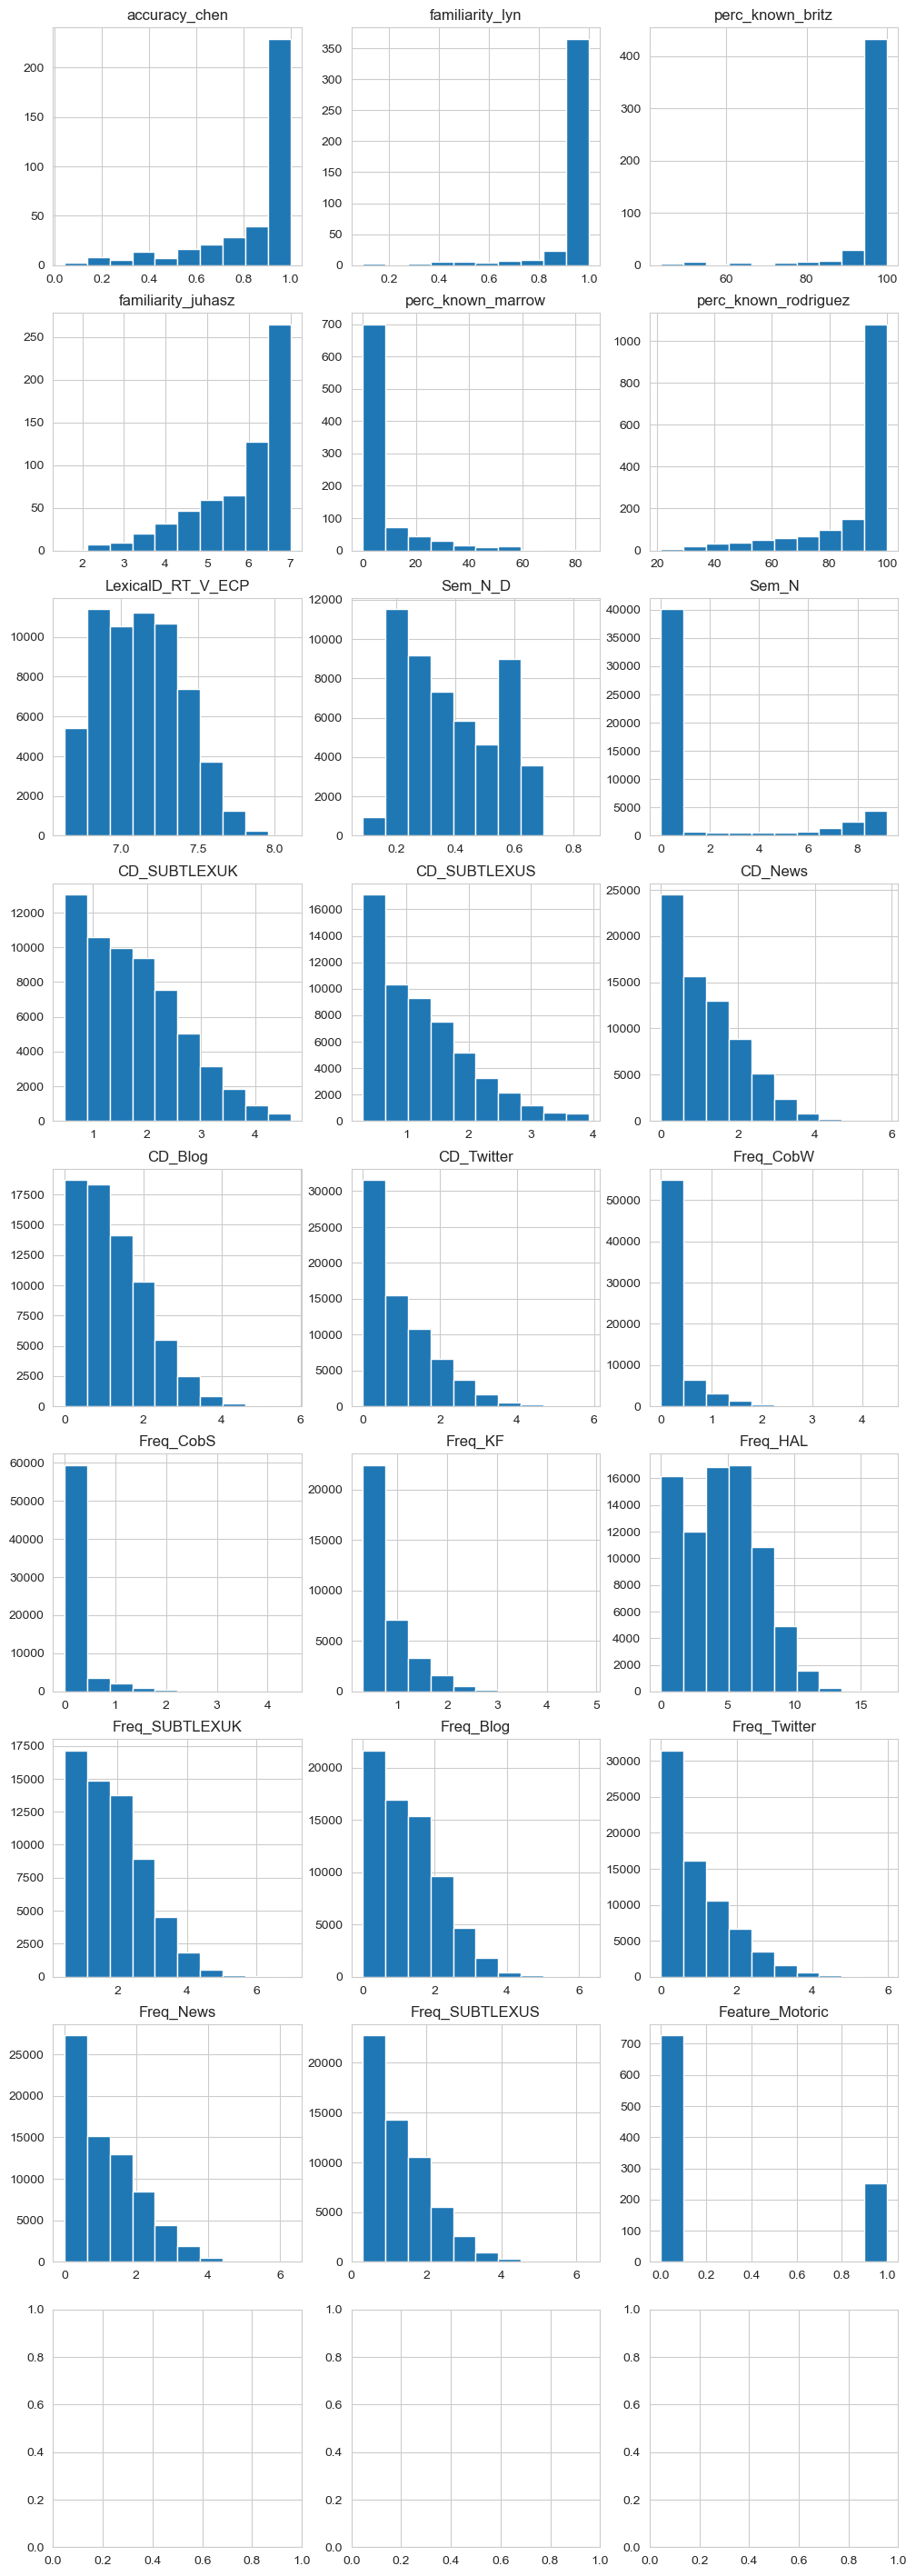

In [18]:
# Generates a grid of histograms for the problematic norms
problematic_norms = problematic['norm'].unique()
n_plots = len(problematic_norms)
n_cols = 3
n_rows = n_plots // n_cols + 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))

for i, norm in enumerate(problematic_norms):
    ax = axs[i // n_cols, i % n_cols]
    norms[norm].hist(ax=ax)
    ax.set_title(norm)


**Conclusions**: very negative r2s are caused by at least one of the following in each case:
1. Skewed distribution (even after logging)
2. p >> train_n
3. Brain embedding 